# Data Collection for Addons Engagement Study

This notebook uses the longitudinal dataset to build a proof-of-concept design matrix for the addons engagement study, which seeks to answer the question: **Does having addons increase user engagement?** *(definition of engagement TBD)*

Specs for this study can be found [here](https://metrics.mozilla.com/protected/dzeber/docs/addons-engagement-study.html), however I've included the **Covariates** section of the spec which includes a preliminary list of variables to include in our design matrix that is subject to change.






### Covariates

The following measures will be included as covariates in the model, in order to control for their effect when analyzing the effect on the response of installing the add-on.

The following system characteristics are intended to describe a user's computing environment/resources, as well as give an indication of their technical knowledge.

- OS
- OS version (Windows only)
- System architecture
- System memory (grouped by 2^n GB)
- Number of physical CPU cores
- (First) graphics adapter vendorID?

There are some other features we want to control for but aren't explicitly interested in.

- Average number of main crashes per session hour
- Initial Firefox version
- Profile creation date (grouped by month)
- Did they have non-system, non-acceptable add-ons?
    + eg. did they have foreign-installed, enabled add-ons?
- Did they enable telemetry by the end of the period?

#### Possible Responses / addition explanatory variables
*These are proposed engagement metrics and are here for reference however it is likely that only a handful will be used, or some combination of them*

The following statistics are aggregated over a period. Together, they characterize a user's pattern of activity and engagement.

- Total number of active days in the period
- Longest run of consecutive active days in the period
- Was the profile active on weekends?
- Average number of sessions per active day
- Average uptime per active day (in minutes)
- Average usage intensity (percentage of uptime that was "active")
- Did they configure sync and link at least one device by the end of the period?
- Was Firefox set as the default browser at the end of the period?
- Did they change their search default at some point during the period?
    + Otherwise, the actual search default at the end of the period: Yahoo/Google/Other
- Did they make any bookmarks during the period?
- Average number of history pages per uptime hour
- Did they make any SAP searches during the period?
    + Otherwise, average search rate (searches per hour)
- Did they change their theme at some point during the period?





Below is the query to get the initial covariates in place. For now, I am taking the first element of the nested arrays containing meta-data about a user's environment (so, the most recent entry, or the last entry we observed for that profile). This is subject to change.

In [77]:
import addons
import pandas as pd
import numpy as np
import pyspark.sql.types as sql_types
import pyspark.sql.functions as fun
import matplotlib.pyplot as plt
import seaborn
seaborn.set_style('whitegrid')
%matplotlib inline

sc.addPyFile('addons.py')

In [15]:
# Cutoffs for when a profile was created
PROF_CREATED_START = "'2016-01-01'"
PROF_CREATED_END   = "'2016-03-31'"

format_pcd = fun.udf(addons.format_time, sql_types.DateType())

query = \
'''
select

--THESE FIELDS ARE NOT NESTED
client_id, os, normalized_channel, 

--THESE FIELDS ARE KEPT NESTED FOR FURTHER MUNGING
submission_date, session_length, active_addons, settings,

--OF THE FOLLOWING NESTED FIELDS, TAKE DATA FROM NEWEST ENTRY
geo_country[1] as geo_country,
profile_creation_date[1] as profile_creation_date,
settings[1].locale as locale,
system[1].memory_mb as memory_mb,
system_device[1].model as device_model,
system_device[1].manufacturer as device_manufac,
system_device[1].hardware as device_hardware,
system_device[1].is_tablet as device_is_tablet,
system_os[1].name as system_os,
system_os[1].version as system_os_version,
system_os[1].locale as system_os_locale,
build[1].application_name as application_name,
build[1].architecture as architecture,
build[1].version as build_version,
build[1].build_id as build_id,
build[1].vendor as vendor,
system_cpu[1].cores as cores,
system_gfx[1].adapters.vendor_id[1] as gfx_vendor_id

from longitudinal
where profile_creation_date[1] >= {}
and   profile_creation_date[1] <= {}
'''.format(PROF_CREATED_START, PROF_CREATED_END)


dataset = sqlContext.sql(query)

In [3]:
dataset.printSchema()

root
 |-- client_id: string (nullable = true)
 |-- os: string (nullable = true)
 |-- normalized_channel: string (nullable = true)
 |-- submission_date: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- session_length: array (nullable = true)
 |    |-- element: long (containsNull = true)
 |-- active_addons: array (nullable = true)
 |    |-- element: map (containsNull = true)
 |    |    |-- key: string
 |    |    |-- value: struct (valueContainsNull = true)
 |    |    |    |-- blocklisted: boolean (nullable = true)
 |    |    |    |-- description: string (nullable = true)
 |    |    |    |-- name: string (nullable = true)
 |    |    |    |-- user_disabled: boolean (nullable = true)
 |    |    |    |-- app_disabled: boolean (nullable = true)
 |    |    |    |-- version: string (nullable = true)
 |    |    |    |-- scope: integer (nullable = true)
 |    |    |    |-- type: string (nullable = true)
 |    |    |    |-- foreign_install: boolean (nullable = true)
 | 

In [4]:
dataset.count()

595090

We have the data we want here, but we still need to create aggregates for each profile in each period. The data we just created has profiles that were created sometime in Jan-March, 2016. The model we've proposed uses [Difference-in-Differences Estimation](https://en.wikipedia.org/wiki/Difference_in_differences), which uses observational data to simulate an experimental research study design. What this means is we need to "apply" a treatment to a portion of our data over some time period, however this treatment is observed. In this case, the treatment is whether or not a user has installed an addon at some point in the study period. 

To do this, we also need to construct pre and post periods. The pre period contains profiles that have not yet installed an addon (both treatment and control groups have 0 (non-system, user_enabled, non-foreign_installed) addons. The post period contains the same profiles, however the treament group has installed an addon whereas the control group still has not. Since profiles install addons at different times, there is no clean cutoff time for splitting our data into a pre and post period. Choosing this cutoff will require some thought to ensure that we not only sufficiently observe users behavior before installing an addon, but also to ensure that the treatment and control groups are relatively balanced. 

First, we need to figure out when users have installed their first addon, specifically a non-system addon, that wasn't foreign installed and that isn't disabled (i.e. the user actively installed this addon and is using it). To simplify this problem, we can look at when a user installed a *specific* addon and use this as the treatment indicator. Below I define `ADDON_GUID` as the GUID for Adblock Plus. 


Some things to Note:
   * I create a new column that is a `Struct` object with three fields:
       * **date**: the date of a user's first install
       * **group**: A profile can belong to one of three groups under this framework:
          * `match`: the addon_id in question is the first install (or among the first installed addons)
          * `other`: the addon_id in question is not the first installed addon
          * `no-match`: no addons have been installed
       * **idx**: The index of the ping that contains the first install
           * This will be useful later on when splitting into pre and post

In [8]:
# Adblock plus
ADDON_GUID='{d10d0bf8-f5b5-c8b4-a8b2-2b9879e08c5d}'

def addon_first_installed(addon_lst, date):
    '''
    Finds the date and index of the first entry that contains some
    addon_id as a key (defined globally) i.e., when was this addon
    first installed. In addition the addon must be the first addon
    or among the first addons installed for a user.
    
    addon_lst: list of dicts of size n or None
    date:      list of dates of size n or None
    
    return (date, index)
    '''
    try:
        n = len(addon_lst)
    except TypeError:
        return (None, -1, 'no_addons')
    
    # iterate starting from last index
    for i in range(n-1, -1, -1):
        current = addon_lst[i]
        if current is None or len(current) == 0:
            continue
        found_eligible = False
        for addon in current:
            if not current[addon]['foreign_install'] \
            and not current[addon]['user_disabled'] \
            and addon not in addons.SYSTEM_ADDONS:
                found_eligible = True
                if addon == ADDON_GUID:
                    return (addons.format_time(date[i]), i, 'match')
        if found_eligible:
            return (addons.format_time(date[i]), i, 'other')
    return (None, -1, 'no_addons')


addon_first_installed = fun.udf(addon_first_installed, 
                                sql_types.StructType([
                                        sql_types.StructField("date", sql_types.DateType(), True),
                                        sql_types.StructField("idx",  sql_types.IntegerType(), True),
                                        sql_types.StructField("group",sql_types.StringType(), True)
                                        ]))  

Format `profile_creation_date` and apply `addon_first_installed()` to the `active_addons` and `submission_date` columns:

In [24]:
d = dataset.withColumn('creation_date', fun.to_date(format_time('profile_creation_date'))).drop('profile_creation_date') \
           .withColumnRenamed('creation_date', 'profile_creation_date')  \
           .withColumn('first_install', addon_first_installed('active_addons', 'submission_date')).cache()

In [19]:
d.groupBy(d.first_install.group).count().collect()

[Row(first_install[group]=u'no_addons', count=386103),
 Row(first_install[group]=u'match', count=46362),
 Row(first_install[group]=u'other', count=162625)]

Above we see the counts for the three groups in our data. We have 46,362 profiles that installed (in this case) Adblock Plus as their first addon, or it was among the first addons installed. We can now select from this group to form our treatment group under the restriction that the profile must have had at least 2 weeks(?) (or some measure) of activity before installing Adblock Plus to enure we have observed sufficient data for the pre period for each test profile.

Off the top of my head this could be handled two ways:
* take the difference between the profile creation date and the first install date
    * simple and clear, but what if a user had, say, only one or two sessions two weeks ago, and then decided to install Ablock Plus on the second or third session? Just using this difference doesn't ensure we've seen ample **activity**, although it's my intuition that in most cases we will.
       * we can use the `idx` field to see how many pings were submitted before the first install to check this.
* use some measure (i.e., count # pings before first_install) and apply thresholding


Lets take a look at the distribution of the number of days + pings before a user installs their first addon(s):

In [100]:
# d = d.withColumnRenamed(d.profile_creation_date, format_time(fun.col('profile_creation_date')))
d = d.withColumn('time_to_install', fun.datediff(d.first_install.date, d.profile_creation_date))

d_filtered = d.filter('time_to_install is not null')
d_filtered.select('profile_creation_date', 'first_install', 'time_to_install').show()

+---------------------+--------------------+---------------+
|profile_creation_date|       first_install|time_to_install|
+---------------------+--------------------+---------------+
|           2016-03-15|[2016-05-29,91,ot...|             75|
|           2016-03-10|[2016-03-23,1,other]|             13|
|           2016-01-30|[2016-03-18,430,o...|             48|
|           2016-03-23|[2016-03-23,630,o...|              0|
|           2016-03-19|[2016-03-20,209,m...|              1|
|           2016-03-27|[2016-04-04,859,m...|              8|
|           2016-03-23|[2016-07-16,3,other]|            115|
|           2016-03-08|[2016-04-25,15,ot...|             48|
|           2016-02-08|[2016-04-16,912,o...|             68|
|           2016-03-18|[2016-05-13,469,o...|             56|
|           2016-02-21|[2016-03-27,196,m...|             35|
|           2016-01-10|[2016-04-12,66,ma...|             93|
|           2016-01-23|[2016-04-23,16,ma...|             91|
|           2016-01-25|[

In [51]:
time_to_install = map(lambda x: x.time_to_install, d_filtered.select('time_to_install').collect())

In [46]:
pings_before_install = map(lambda x: x.asDict().values()[0], d_filtered.select(d.first_install.idx).collect())

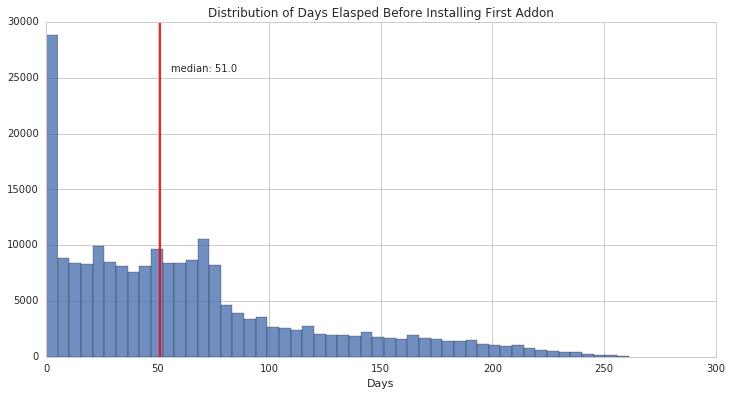

In [99]:
plt.figure(figsize=(12, 6))
# filter out the few negative values
time_to_install = [i for i in time_to_install if i >= 0]
plt.hist(time_to_install, bins=50, alpha=.8)
plt.title('Distribution of Days Elasped Before Installing First Addon')
plt.xlabel('Days')
med = np.median(time_to_install)
plt.vlines(med, 0, 30000,
          color='red')
plt.text(med+ 5, 25500, "median: " + str(med))
plt.show()

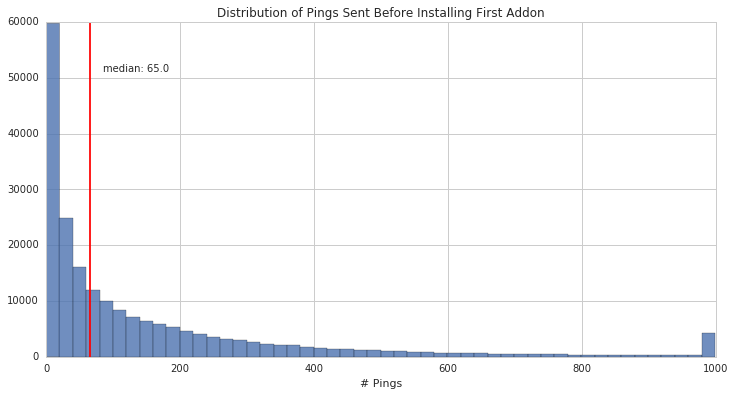

In [98]:
plt.figure(figsize=(12, 6))
plt.hist(pings_before_install, bins=50, alpha=.8)
plt.title('Distribution of Pings Sent Before Installing First Addon')
plt.xlabel('# Pings')
med=np.median(pings_before_install)
plt.vlines(med, 0, 60000,
          color='red')
plt.text(med+ 20, 51000, "median: " + str(med))
plt.show()

Looking at these plots, I am fairly confident that we will observe sufficient data when restricting the pre-period to be >= 14 days before the time of install. We can also filter by the number of pings sent.

So, for now, we can populate the pre-period with profiles who have at least 14 days between profile creation date and the first install date, and who've sent >= 5 pings. These numbers are not final, however I'd like to set up some framework to be tinkered with down the road. I think 5 is a reasonable choice for the number of pings for it allows a user to use the browser for, as an example, a work week and I dont expect this filter to heavily subset our data.

*Checkpoint EOD 9/27*